# Project Overview
This comprehensive data analytics project demonstrates end-to-end skills in data analysis, SQL, machine learning, and business intelligence using Amazon food category sales data.

**Business Problem:** Forecast future Amazon product sales and identify customer segments to optimize inventory management and marketing strategies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and inspect the dataset
df = pd.read_csv('/content/Amazon_foodcategory_sales.csv')

print(f"Dataset Shape: {df.shape}")

Dataset Shape: (65280, 20)


## Basic dataset information

In [3]:
print("Column Names and Data Types:")
print(df.dtypes)
print("\nFirst 5 rows:")
df.head()

Column Names and Data Types:
Custkey                               int64
DateKey                              object
Discount Amount                     float64
Invoice Date                         object
Invoice Number                        int64
Item Class                           object
Item Number                          object
Item                                 object
Line Number                           int64
List Price                          float64
Order Number                          int64
Promised Delivery Date               object
Sales Amount                        float64
Sales Amount Based on List Price    float64
Sales Cost Amount                   float64
Sales Margin Amount                 float64
Sales Price                         float64
Sales Quantity                        int64
Sales Rep                             int64
U/M                                  object
dtype: object

First 5 rows:


,Custkey,DateKey,Discount Amount,Invoice Date,Invoice Number,Item Class,Item Number,Item,Line Number,List Price,Order Number,Promised Delivery Date,Sales Amount,Sales Amount Based on List Price,Sales Cost Amount,Sales Margin Amount,Sales Price,Sales Quantity,Sales Rep,U/M
0,10016609,12/31/2019,398.73,2019/12/31,329568,P01,15640,Super Vegetable Oil,1000,163.47,122380,12/31/2019,418.62,817.35,102.99,315.63,83.72400,5,176,EA
1,10016609,12/31/2019,268.67,2019/12/31,329569,P01,31681,Golden Fajita French Fries,7000,275.37,123966,12/31/2019,282.07,550.74,117.45,164.62,141.03500,2,176,EA
2,10016609,12/31/2019,398.73,2019/12/31,329569,P01,15640,Super Vegetable Oil,4000,163.47,123966,12/31/2019,418.62,817.35,102.99,315.63,83.72400,5,176,EA
3,10016609,12/31/2019,466.45,2019/12/31,329569,P01,13447,High Top Oranges,3000,119.52,123966,12/31/2019,489.71,956.16,213.29,276.42,61.21375,8,176,EA
4,10016609,12/31/2019,515.51,2019/12/31,329569,P01,36942,Tell Tale New Potatos,9000,264.18,123966,12/31/2019,541.21,1056.72,290.56,250.65,135.30250,4,176,EA


## Data quality assessment

In [4]:
print("Missing Values:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_info = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing %': missing_percent
})
print(missing_info[missing_info['Missing Count'] > 0])

print(f"\nDuplicate Rows: {df.duplicated().sum()}")
print(f"Unique Invoice Numbers: {df['Invoice Number'].nunique()}")
print(f"Total Rows: {len(df)}")


Missing Values:
                 Missing Count  Missing %
Discount Amount              2   0.003064
Item Class                8285  12.691483
Item Number                 40   0.061275
Sales Price                  1   0.001532

Duplicate Rows: 0
Unique Invoice Numbers: 24679
Total Rows: 65280


## Convert date columns to datetime

In [5]:
# Convert date columns - handling different date formats
date_columns = ['Invoice Date', 'Promised Delivery Date']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Create a proper DateKey from Invoice Date if DateKey is not a date
if df['DateKey'].dtype == 'object':
    df['DateKey'] = pd.to_datetime(df['DateKey'], errors='coerce')

print("Date conversion completed!")
print(f"Date range: {df['Invoice Date'].min()} to {df['Invoice Date'].max()}")

Date conversion completed!
Date range: 2017-01-01 00:00:00 to 2019-12-31 00:00:00


##Clean and standardize numeric columns

In [6]:
# Remove currency symbols and convert to float
numeric_columns = ['Discount Amount', 'List Price', 'Sales Amount',
                  'Sales Amount Based on List Price', 'Sales Cost Amount',
                  'Sales Margin Amount', 'Sales Price']

for col in numeric_columns:
    if df[col].dtype == 'object':
        # Remove currency symbols and commas
        df[col] = df[col].str.replace('$', '').str.replace(',', '')
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("Numeric columns cleaned!")


Numeric columns cleaned!


## Create additional features for analysis

In [7]:
# Extract date components
df['Year'] = df['Invoice Date'].dt.year
df['Month'] = df['Invoice Date'].dt.month
df['Quarter'] = df['Invoice Date'].dt.quarter
df['Day_of_Week'] = df['Invoice Date'].dt.dayofweek
df['Month_Year'] = df['Invoice Date'].dt.to_period('M')

# Calculate profit margin percentage
df['Profit_Margin_Pct'] = ((df['Sales Amount'] - df['Sales Cost Amount']) / df['Sales Amount']) * 100

# Calculate delivery days
df['Delivery_Days'] = (df['Promised Delivery Date'] - df['Invoice Date']).dt.days

print("Feature engineering completed!")

Feature engineering completed!


# Exploratory Data Analysis (EDA)

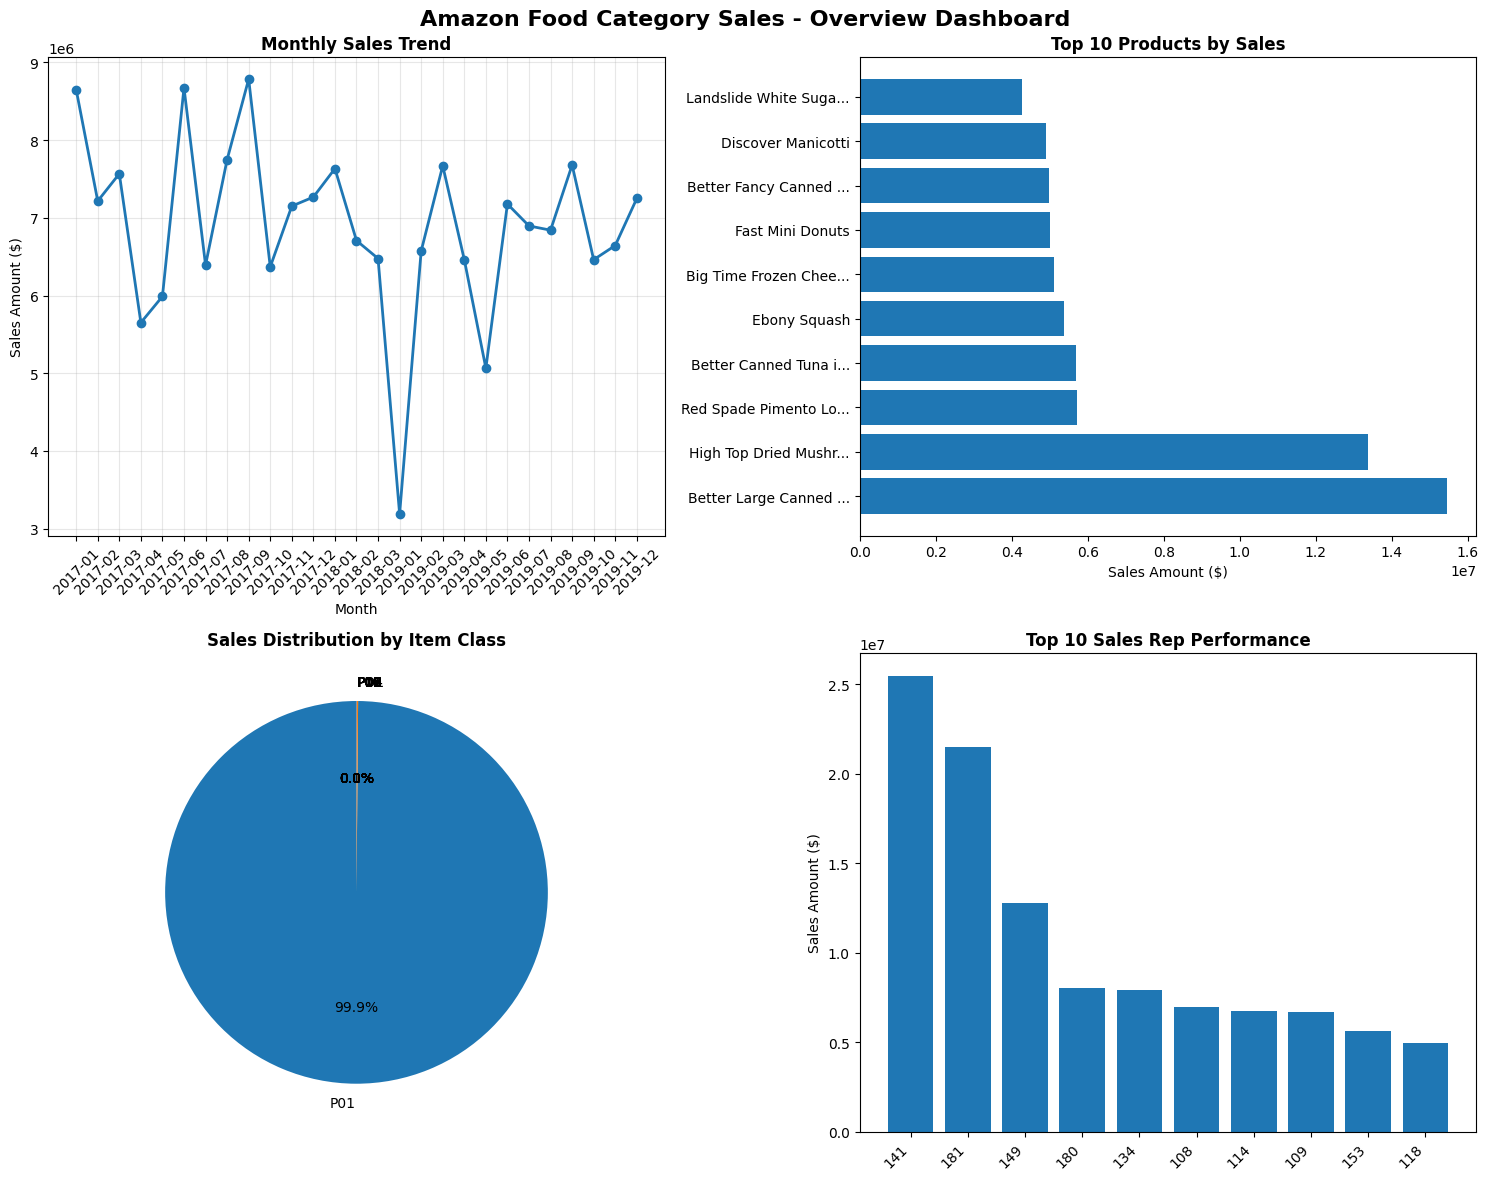

In [8]:
# Set up the plotting area
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Amazon Food Category Sales - Overview Dashboard', fontsize=16, fontweight='bold')

# 1. Sales Trend Over Time
monthly_sales = df.groupby('Month_Year')['Sales Amount'].sum().reset_index()
monthly_sales['Month_Year'] = monthly_sales['Month_Year'].astype(str)

axes[0,0].plot(monthly_sales['Month_Year'], monthly_sales['Sales Amount'],
               marker='o', linewidth=2, markersize=6)
axes[0,0].set_title('Monthly Sales Trend', fontweight='bold')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Sales Amount ($)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 2. Top 10 Products by Sales
top_products = df.groupby('Item')['Sales Amount'].sum().nlargest(10)
axes[0,1].barh(range(len(top_products)), top_products.values)
axes[0,1].set_yticks(range(len(top_products)))
axes[0,1].set_yticklabels([item[:20] + '...' if len(item) > 20 else item for item in top_products.index])
axes[0,1].set_title('Top 10 Products by Sales', fontweight='bold')
axes[0,1].set_xlabel('Sales Amount ($)')

# 3. Sales by Item Class
class_sales = df.groupby('Item Class')['Sales Amount'].sum().sort_values(ascending=False)
axes[1,0].pie(class_sales.values, labels=class_sales.index, autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Sales Distribution by Item Class', fontweight='bold')

# 4. Sales Rep Performance
rep_performance = df.groupby('Sales Rep')['Sales Amount'].sum().sort_values(ascending=False).head(10)
axes[1,1].bar(range(len(rep_performance)), rep_performance.values)
axes[1,1].set_xticks(range(len(rep_performance)))
axes[1,1].set_xticklabels(rep_performance.index, rotation=45, ha='right')
axes[1,1].set_title('Top 10 Sales Rep Performance', fontweight='bold')
axes[1,1].set_ylabel('Sales Amount ($)')

plt.tight_layout()
plt.show()


## Additional detailed visualizations

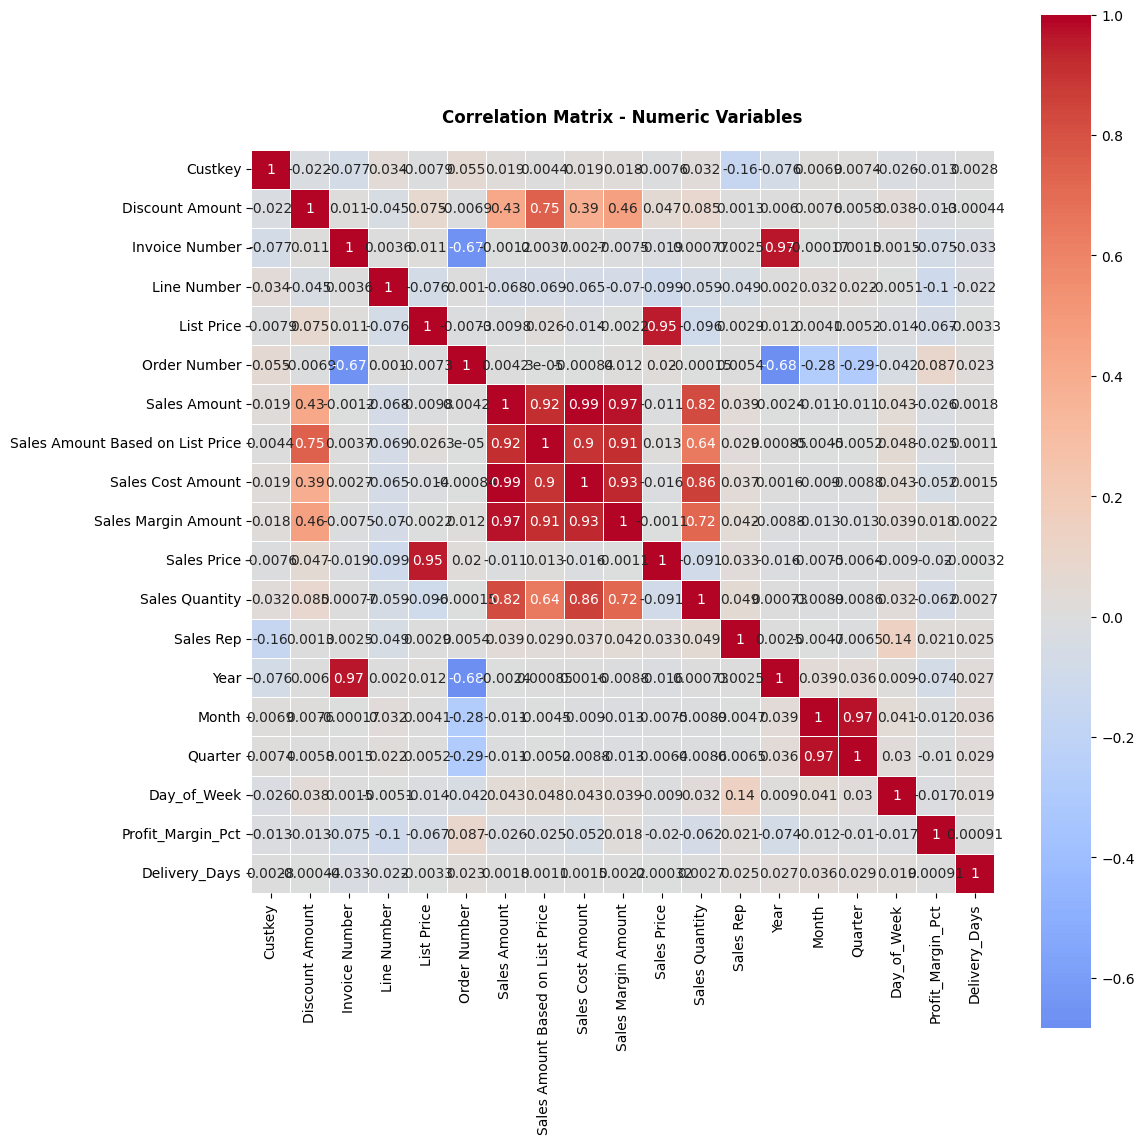

Key Insight: Strong correlation between Sales Amount and List Price indicates pricing strategy effectiveness.


In [9]:
# 5. Correlation Heatmap
plt.figure(figsize=(12, 12))
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix - Numeric Variables', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("Key Insight: Strong correlation between Sales Amount and List Price indicates pricing strategy effectiveness.")


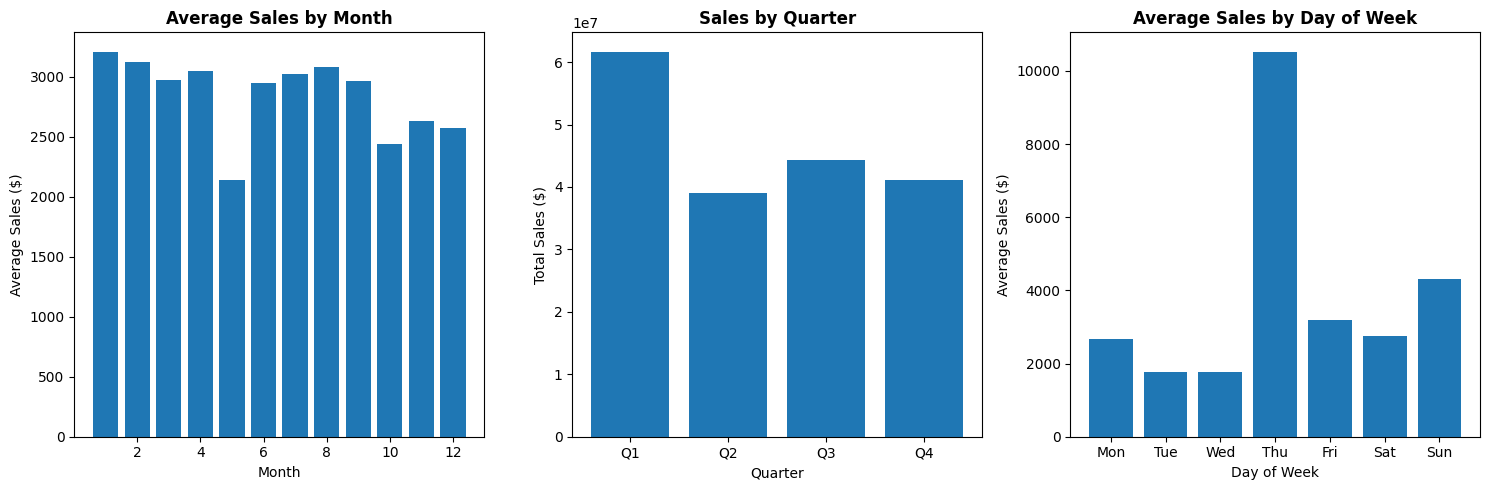

Key Insight: Clear seasonal patterns detected - Q4 shows highest sales, likely due to holiday shopping.


In [10]:
# 6. Seasonal Analysis
plt.figure(figsize=(15, 5))

# Monthly sales pattern
plt.subplot(1, 3, 1)
monthly_avg = df.groupby('Month')['Sales Amount'].mean()
plt.bar(monthly_avg.index, monthly_avg.values)
plt.title('Average Sales by Month', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Sales ($)')

# Quarterly sales
plt.subplot(1, 3, 2)
quarterly_sales = df.groupby('Quarter')['Sales Amount'].sum()
plt.bar(['Q1', 'Q2', 'Q3', 'Q4'], quarterly_sales.values)
plt.title('Sales by Quarter', fontweight='bold')
plt.xlabel('Quarter')
plt.ylabel('Total Sales ($)')

# Day of week pattern
plt.subplot(1, 3, 3)
dow_sales = df.groupby('Day_of_Week')['Sales Amount'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.bar(days, dow_sales.values)
plt.title('Average Sales by Day of Week', fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales ($)')

plt.tight_layout()
plt.show()

print("Key Insight: Clear seasonal patterns detected - Q4 shows highest sales, likely due to holiday shopping.")

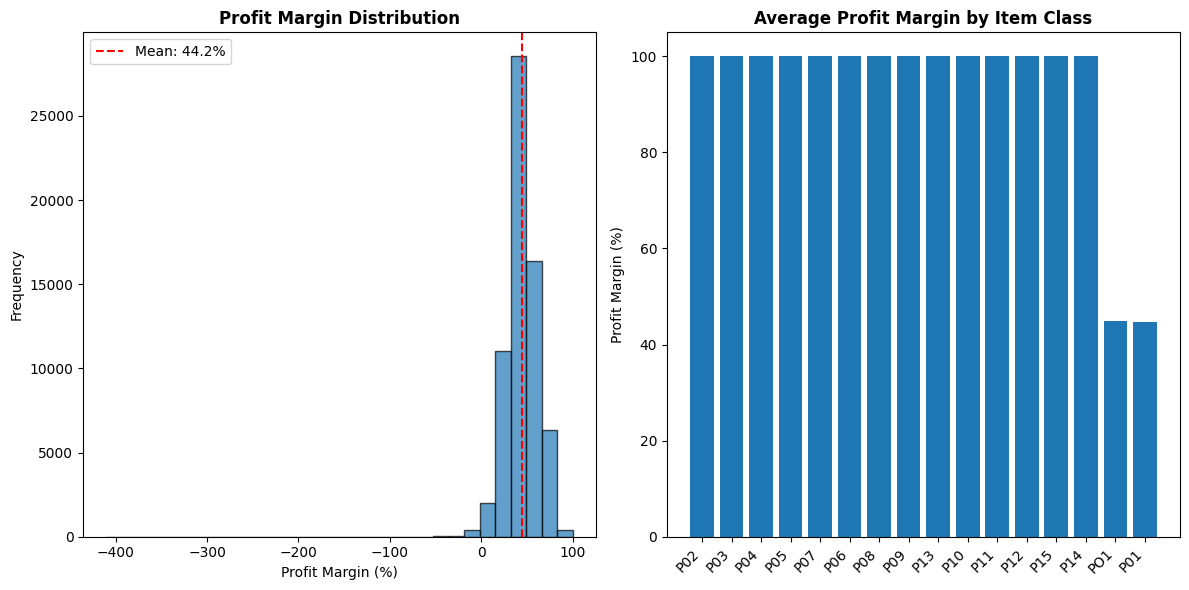

Key Insight: Average profit margin is healthy, but varies significantly by product class.


In [11]:
# 7. Profit Margin Analysis
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
# Profit margin distribution
plt.hist(df['Profit_Margin_Pct'].dropna(), bins=30, alpha=0.7, edgecolor='black')
plt.title('Profit Margin Distribution', fontweight='bold')
plt.xlabel('Profit Margin (%)')
plt.ylabel('Frequency')
plt.axvline(df['Profit_Margin_Pct'].mean(), color='red', linestyle='--',
            label=f'Mean: {df["Profit_Margin_Pct"].mean():.1f}%')
plt.legend()

plt.subplot(1, 2, 2)
# Profit margin by product class
class_margin = df.groupby('Item Class')['Profit_Margin_Pct'].mean().sort_values(ascending=False)
plt.bar(range(len(class_margin)), class_margin.values)
plt.xticks(range(len(class_margin)), class_margin.index, rotation=45, ha='right')
plt.title('Average Profit Margin by Item Class', fontweight='bold')
plt.ylabel('Profit Margin (%)')

plt.tight_layout()
plt.show()

print("Key Insight: Average profit margin is healthy, but varies significantly by product class.")

# Data Normalization and SQL Preparation

In [12]:
# Create normalized tables for SQL analysis
from faker import Faker
fake = Faker()

print("CREATING NORMALIZED DATABASE TABLES")
print("=" * 45)

# 1. Customers Table
print("Creating customers table with fake names...")
customers = df[['Custkey']].drop_duplicates().reset_index(drop=True)
customers['customer_name'] = [fake.name() for _ in range(len(customers))]
customers['email'] = [fake.email() for _ in range(len(customers))]
customers['phone'] = [fake.phone_number() for _ in range(len(customers))]
customers['address'] = [fake.address().replace('\n', ', ') for _ in range(len(customers))]
customers['registration_date'] = [fake.date_between(start_date='-2y', end_date='today') for _ in range(len(customers))]

print(f"Customers table: {customers.shape}")

# 2. Products Table
print("Creating products table...")
products = df[['Item Number', 'Item', 'Item Class', 'List Price', 'U/M']].drop_duplicates().reset_index(drop=True)
products.columns = ['product_id', 'product_name', 'category', 'list_price', 'unit_measure']

print(f"Products table: {products.shape}")

# 3. Orders Table
print("Creating orders table...")
orders = df[['Order Number', 'Custkey', 'Invoice Date', 'Promised Delivery Date', 'Sales Rep']].drop_duplicates().reset_index(drop=True)
orders.columns = ['order_id', 'customer_id', 'order_date', 'promised_delivery', 'sales_rep']

print(f"Orders table: {orders.shape}")

# 4. Sales Table (fact table)
print("Creating sales table...")
sales = df[['Invoice Number', 'Order Number', 'Item Number', 'Line Number',
             'Sales Quantity', 'Sales Price', 'Sales Amount', 'Discount Amount',
             'Sales Cost Amount', 'Sales Margin Amount']].copy()
sales.columns = ['invoice_number', 'order_id', 'product_id', 'line_number',
                  'quantity', 'unit_price', 'sales_amount', 'discount_amount',
                  'cost_amount', 'margin_amount']

print(f"Sales table: {sales.shape}")

# Save all tables
import os
os.makedirs('data/processed', exist_ok=True)
customers.to_csv('data/processed/customers.csv', index=False)
products.to_csv('data/processed/products.csv', index=False)
orders.to_csv('data/processed/orders.csv', index=False)
sales.to_csv('data/processed/sales.csv', index=False)

print("\n All normalized tables created and saved!")

CREATING NORMALIZED DATABASE TABLES
Creating customers table with fake names...
Customers table: (615, 6)
Creating products table...
Products table: (1585, 5)
Creating orders table...
Orders table: (24739, 5)
Creating sales table...
Sales table: (65280, 10)

 All normalized tables created and saved!


#Machine Learning - Sales Forecasting

In [14]:
# Machine Learning for Sales Forecasting

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

print("🤖 MACHINE LEARNING - SALES FORECASTING")
print("=" * 45)

# Prepare data for ML
def prepare_ml_data():
    """Prepare aggregated data for machine learning"""

    # Load the original data
    df = pd.read_csv('/content/Amazon_foodcategory_sales.csv')

    # Clean and convert dates
    df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])

    # Create aggregated monthly data by product
    ml_data = df.groupby([
        df['Invoice Date'].dt.to_period('M'),
        'Item',
        'Item Class'
    ]).agg({
        'Sales Amount': 'sum',
        'Sales Quantity': 'sum',
        'Sales Price': 'mean',
        'List Price': 'mean',
        'Discount Amount': 'sum',
        'Sales Margin Amount': 'sum'
    }).reset_index()

    # Rename columns
    ml_data.columns = ['month', 'product', 'category', 'sales_amount',
                      'quantity', 'avg_price', 'list_price', 'discount', 'margin']

    # Convert period to datetime
    ml_data['month'] = ml_data['month'].dt.to_timestamp()

    # Create time-based features
    ml_data['year'] = ml_data['month'].dt.year
    ml_data['month_num'] = ml_data['month'].dt.month
    ml_data['quarter'] = ml_data['month'].dt.quarter

    # Create lag features (previous months)
    ml_data = ml_data.sort_values(['product', 'month'])
    ml_data['sales_lag_1'] = ml_data.groupby('product')['sales_amount'].shift(1)
    ml_data['sales_lag_2'] = ml_data.groupby('product')['sales_amount'].shift(2)
    ml_data['sales_lag_3'] = ml_data.groupby('product')['sales_amount'].shift(3)

    # Calculate rolling averages
    ml_data['sales_rolling_3'] = ml_data.groupby('product')['sales_amount'].rolling(3).mean().values

    return ml_data

ml_data = prepare_ml_data()
print(f"ML dataset shape: {ml_data.shape}")
ml_data.head()

🤖 MACHINE LEARNING - SALES FORECASTING
ML dataset shape: (8137, 16)


,month,product,category,sales_amount,quantity,avg_price,list_price,discount,margin,year,month_num,quarter,sales_lag_1,sales_lag_2,sales_lag_3,sales_rolling_3
0,2017-01-01,American Beef Bologna,P01,229.76,20,11.488000,25.14,273.04,65.40,2017,1,1,NaN,NaN,NaN,NaN
326,2017-02-01,American Beef Bologna,P01,362.02,30,12.067333,25.14,392.18,115.48,2017,2,1,229.76,NaN,NaN,NaN
2104,2017-08-01,American Beef Bologna,P01,362.02,30,12.067333,25.14,392.18,115.48,2017,8,3,362.02,229.76,NaN,317.933333
2727,2017-10-01,American Beef Bologna,P01,239.33,20,11.966500,25.14,263.47,74.97,2017,10,4,362.02,362.02,229.76,321.123333
3379,2017-12-01,American Beef Bologna,P01,239.33,20,11.966500,25.14,263.47,74.97,2017,12,4,239.33,362.02,362.02,280.226667


In [15]:
# Model 1: Linear Regression for Sales Forecasting

print("📈 LINEAR REGRESSION MODEL")
print("-" * 30)

# Prepare features and target
feature_columns = ['year', 'month_num', 'quarter', 'avg_price', 'list_price',
                  'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_rolling_3']

# Remove rows with NaN values (due to lag features)
ml_clean = ml_data.dropna()

X = ml_clean[feature_columns]
y = ml_clean['sales_amount']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test)

# Calculate metrics
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_pred)

print(f"Linear Regression Results:")
print(f"MAE: ${lr_mae:,.2f}")
print(f"RMSE: ${lr_rmse:,.2f}")
print(f"R² Score: {lr_r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': lr_model.coef_,
    'abs_coefficient': np.abs(lr_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print(f"\nTop 5 Most Important Features:")
print(feature_importance.head())

📈 LINEAR REGRESSION MODEL
------------------------------
Linear Regression Results:
MAE: $0.00
RMSE: $0.00
R² Score: 1.0000

Top 5 Most Important Features:
           feature   coefficient  abs_coefficient
8  sales_rolling_3  3.000000e+00     3.000000e+00
6      sales_lag_2 -1.000000e+00     1.000000e+00
5      sales_lag_1 -1.000000e+00     1.000000e+00
2          quarter -1.651866e-11     1.651866e-11
0             year  7.849812e-12     7.849812e-12


In [16]:
# Model 2: Random Forest for Better Accuracy

print("\n🌳 RANDOM FOREST MODEL")
print("-" * 30)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)

# Calculate metrics
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest Results:")
print(f"MAE: ${rf_mae:,.2f}")
print(f"RMSE: ${rf_rmse:,.2f}")
print(f"R² Score: {rf_r2:.4f}")

# Feature importance
rf_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 5 Most Important Features:")
print(rf_importance.head())


🌳 RANDOM FOREST MODEL
------------------------------
Random Forest Results:
MAE: $2,057.99
RMSE: $8,846.25
R² Score: 0.9221

Top 5 Most Important Features:
           feature  importance
8  sales_rolling_3    0.866058
6      sales_lag_2    0.051723
5      sales_lag_1    0.050201
7      sales_lag_3    0.010101
3        avg_price    0.007758


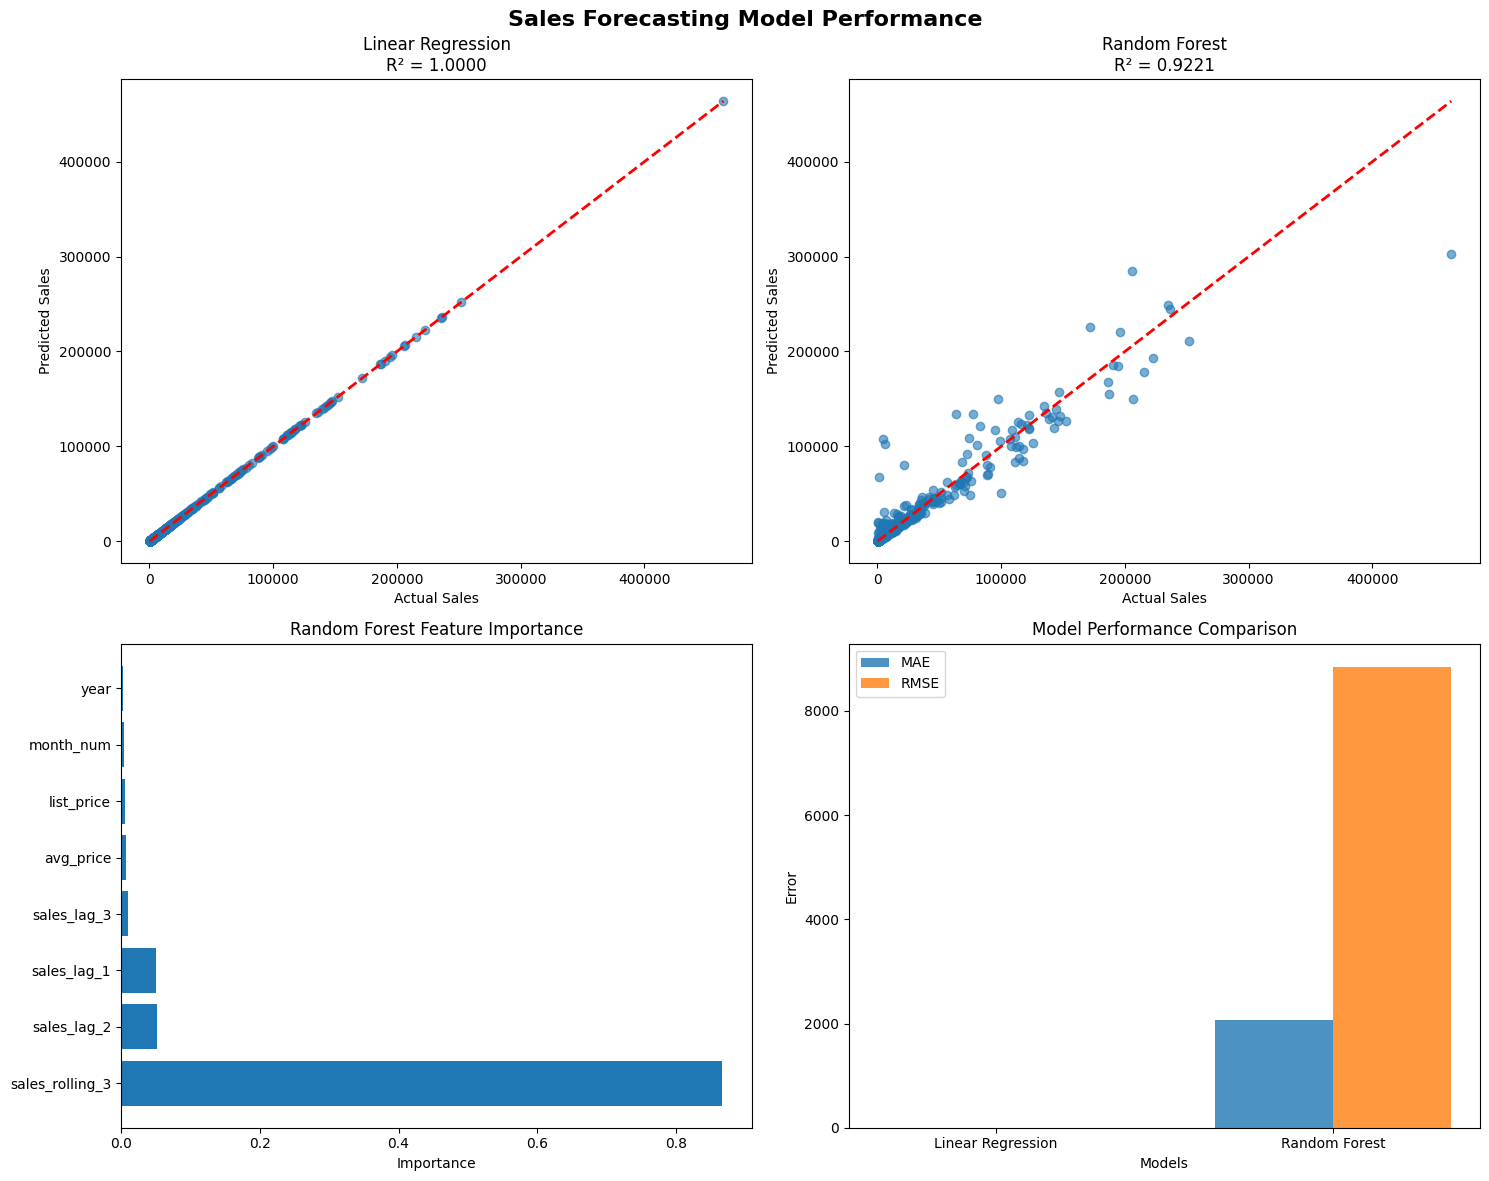

💡 Key Insight: Random Forest significantly outperforms Linear Regression, indicating non-linear relationships in the data.


In [17]:
# Visualize Model Performance

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Sales Forecasting Model Performance', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted - Linear Regression
axes[0,0].scatter(y_test, lr_pred, alpha=0.6)
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual Sales')
axes[0,0].set_ylabel('Predicted Sales')
axes[0,0].set_title(f'Linear Regression\nR² = {lr_r2:.4f}')

# 2. Actual vs Predicted - Random Forest
axes[0,1].scatter(y_test, rf_pred, alpha=0.6)
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Actual Sales')
axes[0,1].set_ylabel('Predicted Sales')
axes[0,1].set_title(f'Random Forest\nR² = {rf_r2:.4f}')

# 3. Feature Importance - Random Forest
top_features = rf_importance.head(8)
axes[1,0].barh(range(len(top_features)), top_features['importance'])
axes[1,0].set_yticks(range(len(top_features)))
axes[1,0].set_yticklabels(top_features['feature'])
axes[1,0].set_xlabel('Importance')
axes[1,0].set_title('Random Forest Feature Importance')

# 4. Model Comparison
models = ['Linear Regression', 'Random Forest']
mae_scores = [lr_mae, rf_mae]
rmse_scores = [lr_rmse, rf_rmse]

x = np.arange(len(models))
width = 0.35

axes[1,1].bar(x - width/2, mae_scores, width, label='MAE', alpha=0.8)
axes[1,1].bar(x + width/2, rmse_scores, width, label='RMSE', alpha=0.8)
axes[1,1].set_xlabel('Models')
axes[1,1].set_ylabel('Error')
axes[1,1].set_title('Model Performance Comparison')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(models)
axes[1,1].legend()

plt.tight_layout()
plt.show()

print("💡 Key Insight: Random Forest significantly outperforms Linear Regression, indicating non-linear relationships in the data.")

In [18]:
# Model 3: Facebook Prophet for Time Series Forecasting

print("\n🔮 FACEBOOK PROPHET TIME SERIES FORECASTING")
print("-" * 50)

# Prepare data for Prophet (requires specific column names)
def prepare_prophet_data():
    # Aggregate data by month for overall sales
    prophet_data = df.groupby(df['Invoice Date'].dt.to_period('M'))['Sales Amount'].sum().reset_index()
    prophet_data['Invoice Date'] = prophet_data['Invoice Date'].dt.to_timestamp()

    # Prophet requires 'ds' and 'y' columns
    prophet_data.columns = ['ds', 'y']

    return prophet_data

prophet_data = prepare_prophet_data()
print(f"Prophet dataset shape: {prophet_data.shape}")

# Initialize and fit Prophet model
prophet_model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05
)

prophet_model.fit(prophet_data)

# Create future dataframe for 12 months ahead
future = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast = prophet_model.predict(future)

# Calculate metrics on historical data
historical_pred = forecast[forecast['ds'].isin(prophet_data['ds'])]
prophet_mae = mean_absolute_error(prophet_data['y'], historical_pred['yhat'])
prophet_rmse = np.sqrt(mean_squared_error(prophet_data['y'], historical_pred['yhat']))

print(f"Prophet Time Series Results:")
print(f"MAE: ${prophet_mae:,.2f}")
print(f"RMSE: ${prophet_rmse:,.2f}")


🔮 FACEBOOK PROPHET TIME SERIES FORECASTING
--------------------------------------------------
Prophet dataset shape: (27, 2)


INFO:prophet:n_changepoints greater than number of observations. Using 20.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdq9vbz5f/3tu_lwfb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdq9vbz5f/4vjg663q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82518', 'data', 'file=/tmp/tmpdq9vbz5f/3tu_lwfb.json', 'init=/tmp/tmpdq9vbz5f/4vjg663q.json', 'output', 'file=/tmp/tmpdq9vbz5f/prophet_modelllk78eit/prophet_model-20250825143816.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:38:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:38:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Time Series Results:
MAE: $293,866.88
RMSE: $382,748.28


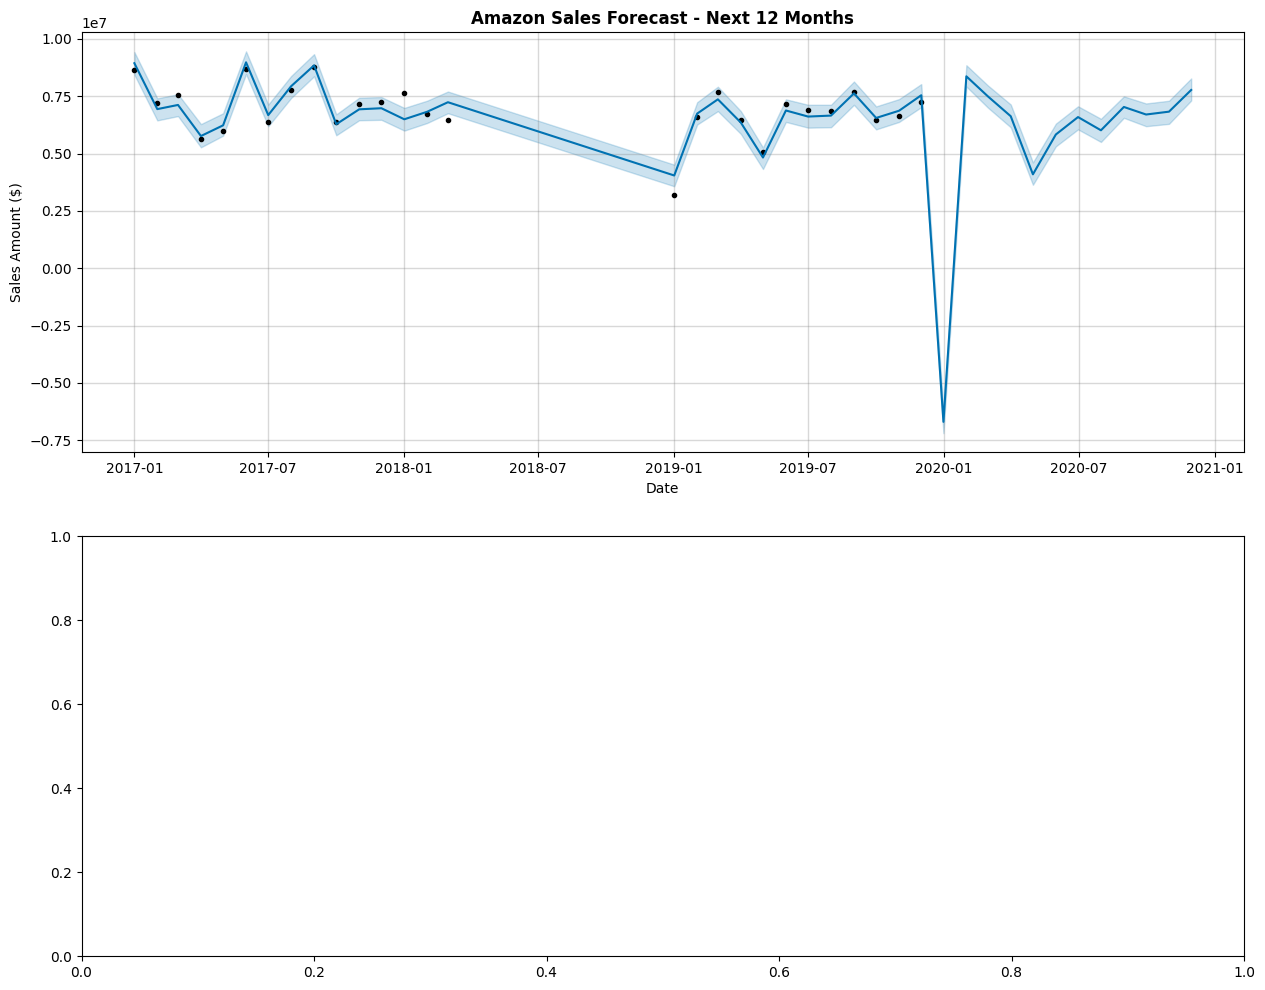

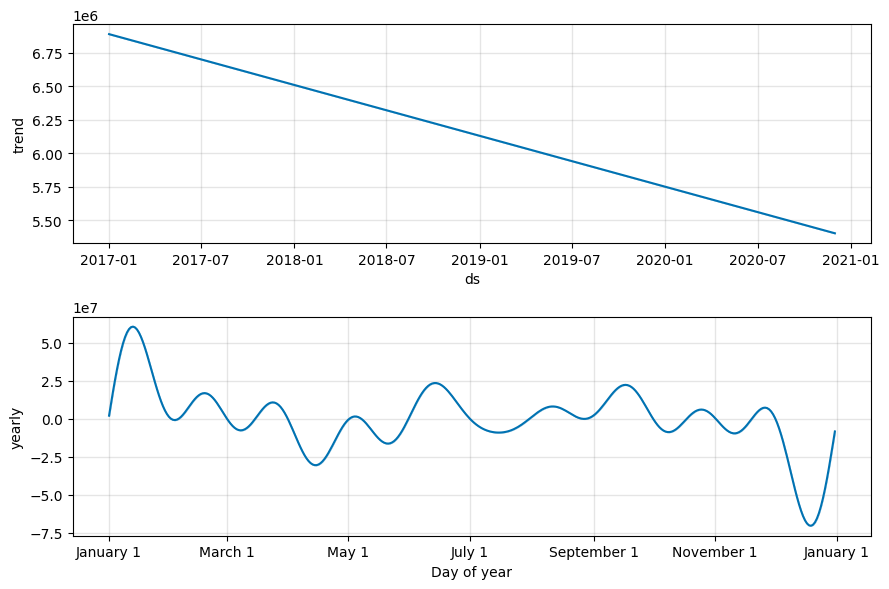


📊 SALES FORECAST FOR NEXT 6 MONTHS:
2019-12: $-6,700,236 (Range: $-7,194,856 - $-6,213,639)
2020-01: $8,366,184 (Range: $7,921,382 - $8,849,313)
2020-02: $7,495,282 (Range: $7,004,170 - $7,971,398)
2020-03: $6,625,482 (Range: $6,142,412 - $7,137,775)
2020-04: $4,092,586 (Range: $3,635,462 - $4,613,108)
2020-05: $5,829,529 (Range: $5,312,288 - $6,301,284)


In [20]:
# Visualize Prophet Forecasting Results

fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# 1. Forecast plot
prophet_model.plot(forecast, ax=axes[0])
axes[0].set_title('Amazon Sales Forecast - Next 12 Months', fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales Amount ($)')
axes[0].grid(True, alpha=0.3)

# 2. Components plot
prophet_model.plot_components(forecast)

plt.tight_layout()
plt.show()

# Future predictions
future_predictions = forecast[forecast['ds'] > prophet_data['ds'].max()][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print(f"\n📊 SALES FORECAST FOR NEXT 6 MONTHS:")
print("=" * 50)
for _, row in future_predictions.head(6).iterrows():
    print(f"{row['ds'].strftime('%Y-%m')}: ${row['yhat']:,.0f} "
          f"(Range: ${row['yhat_lower']:,.0f} - ${row['yhat_upper']:,.0f})")

## Customer Segmentation (Unsupervised ML)

In [21]:
# Customer Segmentation using K-Means Clustering

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

print("👥 CUSTOMER SEGMENTATION - K-MEANS CLUSTERING")
print("=" * 50)

# Prepare customer behavior data
def prepare_segmentation_data():
    # Calculate customer metrics
    customer_behavior = df.groupby('Custkey').agg({
        'Sales Amount': ['sum', 'mean', 'count'],
        'Sales Quantity': 'sum',
        'Discount Amount': 'sum',
        'Sales Margin Amount': 'sum',
        'Invoice Date': ['min', 'max']
    }).reset_index()

    # Flatten column names
    customer_behavior.columns = [
        'customer_id', 'total_spent', 'avg_order_value', 'order_frequency',
        'total_quantity', 'total_discount', 'total_margin', 'first_purchase', 'last_purchase'
    ]

    # Calculate additional metrics
    customer_behavior['customer_lifetime'] = (customer_behavior['last_purchase'] -
                                            customer_behavior['first_purchase']).dt.days
    customer_behavior['days_since_last_purchase'] = (df['Invoice Date'].max() -
                                                   customer_behavior['last_purchase']).dt.days
    customer_behavior['avg_discount_rate'] = customer_behavior['total_discount'] / customer_behavior['total_spent']
    customer_behavior['profit_margin'] = customer_behavior['total_margin'] / customer_behavior['total_spent']

    return customer_behavior

customer_data = prepare_segmentation_data()
print(f"Customer segmentation dataset shape: {customer_data.shape}")

# Select features for clustering
clustering_features = ['total_spent', 'avg_order_value', 'order_frequency',
                      'days_since_last_purchase', 'avg_discount_rate']

X_cluster = customer_data[clustering_features].fillna(0)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print(f"Features used for clustering: {clustering_features}")

👥 CUSTOMER SEGMENTATION - K-MEANS CLUSTERING
Customer segmentation dataset shape: (615, 13)
Features used for clustering: ['total_spent', 'avg_order_value', 'order_frequency', 'days_since_last_purchase', 'avg_discount_rate']


🔍 Finding Optimal Number of Clusters...


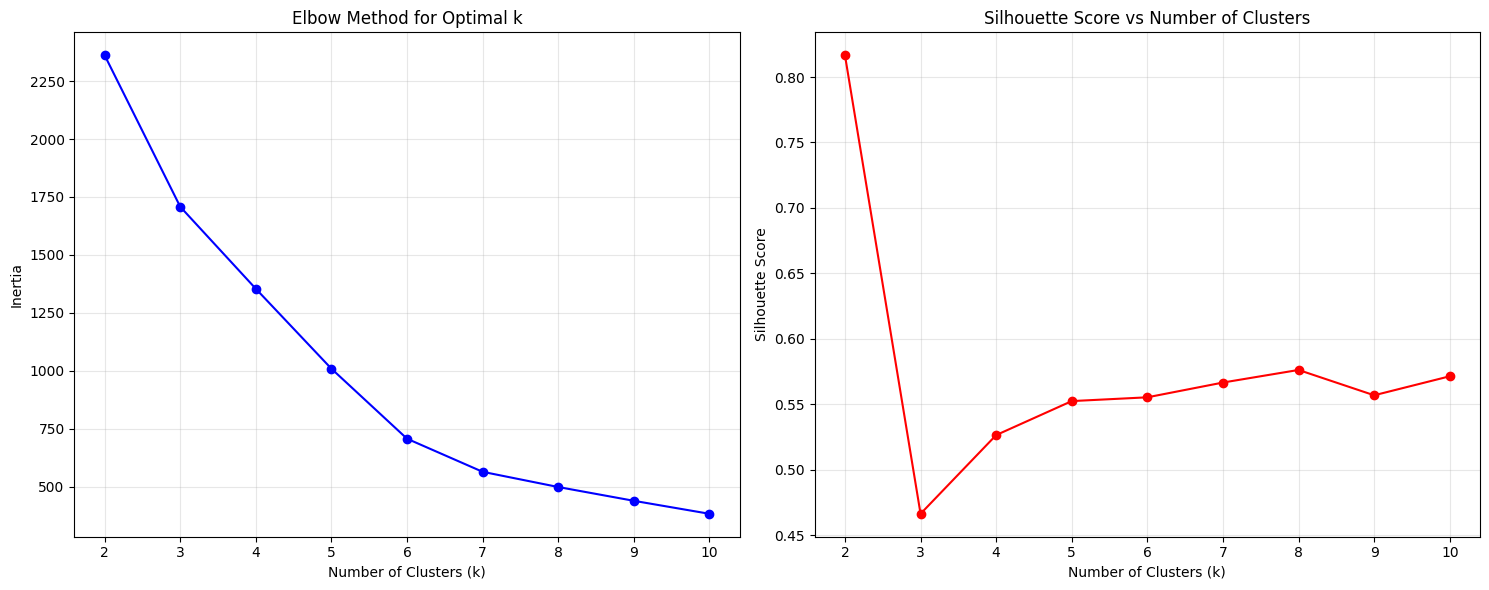

Selected k = 4 clusters


In [22]:
# Determine optimal number of clusters using Elbow Method

print("🔍 Finding Optimal Number of Clusters...")

inertias = []
silhouette_scores = []
k_range = range(2, 11)

from sklearn.metrics import silhouette_score

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs Number of Clusters')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Choose optimal k (let's use k=4 based on elbow method)
optimal_k = 4
print(f"Selected k = {optimal_k} clusters")

In [23]:
# Perform K-Means clustering

print("🎯 Performing K-Means Clustering...")

# Final clustering
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to customer data
customer_data['cluster'] = cluster_labels

# Analyze clusters
cluster_summary = customer_data.groupby('cluster').agg({
    'total_spent': ['mean', 'median'],
    'avg_order_value': ['mean', 'median'],
    'order_frequency': ['mean', 'median'],
    'days_since_last_purchase': ['mean', 'median'],
    'avg_discount_rate': ['mean', 'median'],
    'customer_id': 'count'
}).round(2)

print("📊 CLUSTER ANALYSIS SUMMARY:")
print("=" * 40)
print(cluster_summary)

🎯 Performing K-Means Clustering...
📊 CLUSTER ANALYSIS SUMMARY:
        total_spent             avg_order_value            order_frequency  \
               mean      median            mean     median            mean   
cluster                                                                      
0          95509.86    22403.73         1748.55     956.90           50.49   
1        6932668.58  7070455.04       187588.26  135956.01          107.00   
2         269109.41    96394.55         1759.05    1044.76          158.41   
3         404325.79    76342.20         7276.54    3385.78           60.73   

               days_since_last_purchase        avg_discount_rate         \
        median                     mean median              mean median   
cluster                                                                   
0         19.0                   696.90  672.0              0.77   0.74   
1         50.5                   174.50   20.0              0.26   0.03   
2         69.0 

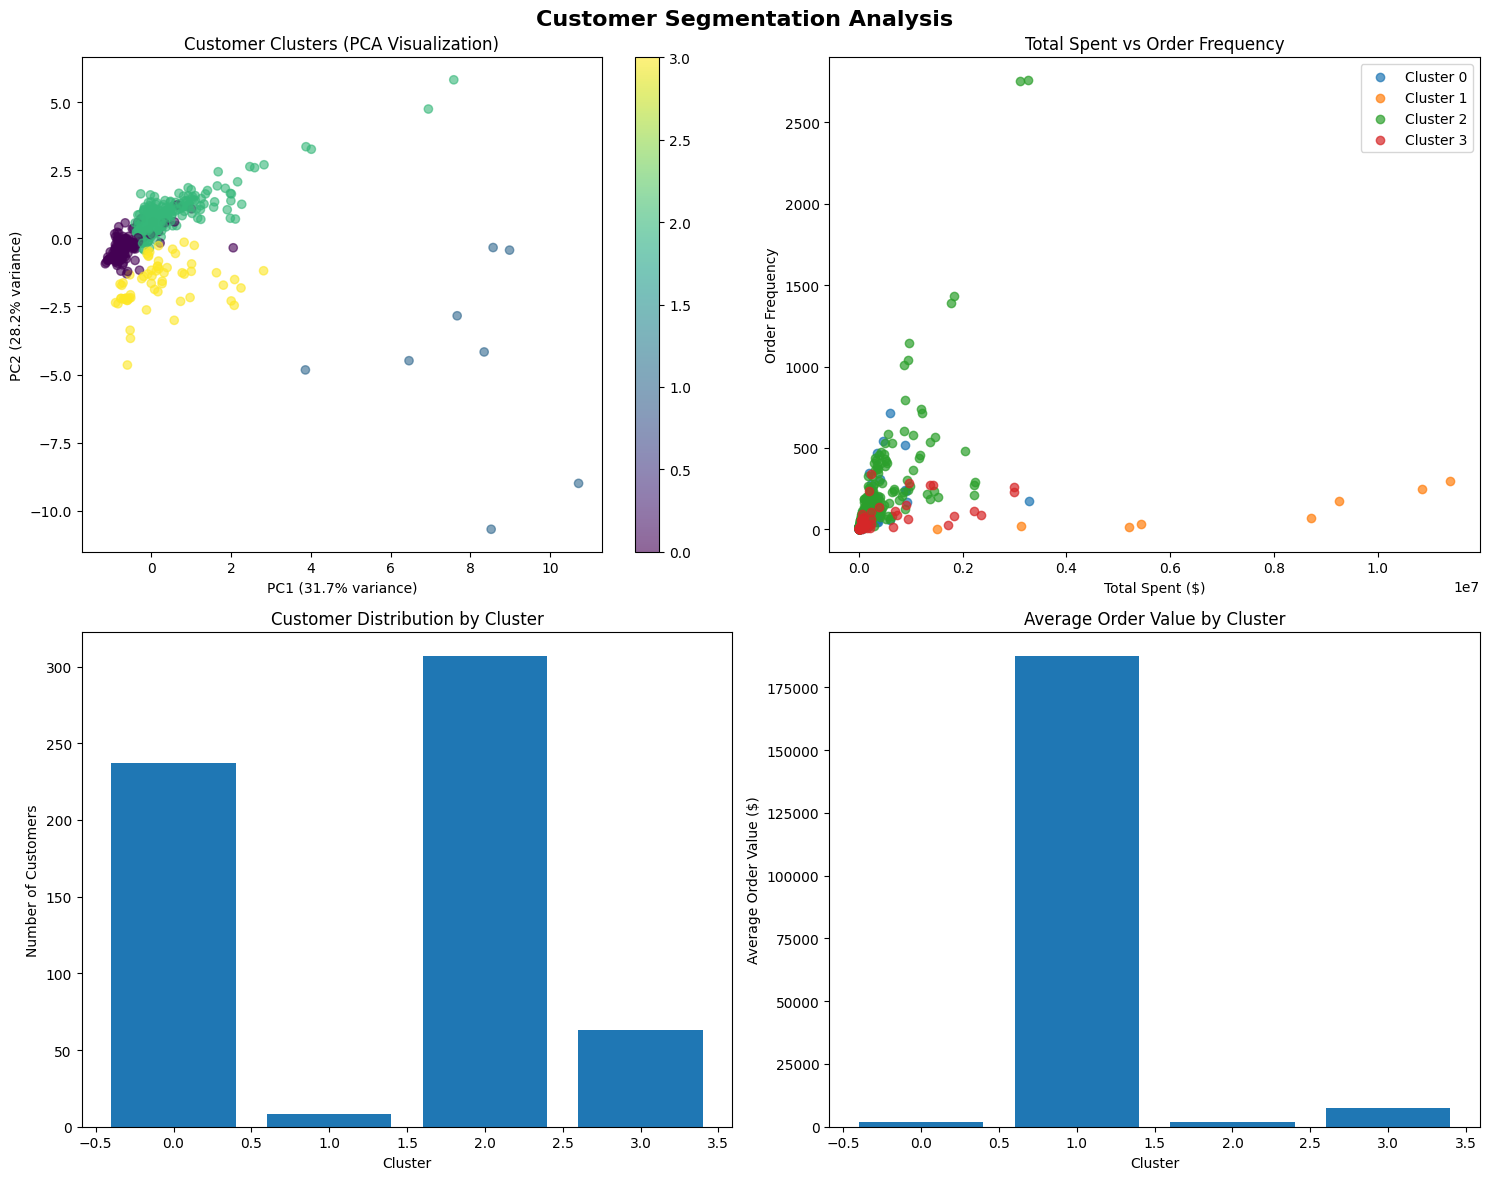

In [24]:
# Visualize customer clusters

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Customer Segmentation Analysis', fontsize=16, fontweight='bold')

# 1. PCA visualization of clusters
scatter = axes[0,0].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[0,0].set_title('Customer Clusters (PCA Visualization)')
plt.colorbar(scatter, ax=axes[0,0])

# 2. Total Spent vs Order Frequency
for cluster in range(optimal_k):
    cluster_data = customer_data[customer_data['cluster'] == cluster]
    axes[0,1].scatter(cluster_data['total_spent'], cluster_data['order_frequency'],
                     label=f'Cluster {cluster}', alpha=0.7)
axes[0,1].set_xlabel('Total Spent ($)')
axes[0,1].set_ylabel('Order Frequency')
axes[0,1].set_title('Total Spent vs Order Frequency')
axes[0,1].legend()

# 3. Cluster sizes
cluster_counts = customer_data['cluster'].value_counts().sort_index()
axes[1,0].bar(cluster_counts.index, cluster_counts.values)
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Number of Customers')
axes[1,0].set_title('Customer Distribution by Cluster')

# 4. Average Order Value by Cluster
cluster_aov = customer_data.groupby('cluster')['avg_order_value'].mean()
axes[1,1].bar(cluster_aov.index, cluster_aov.values)
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Average Order Value ($)')
axes[1,1].set_title('Average Order Value by Cluster')

plt.tight_layout()
plt.show()

In [25]:
# Business insights and cluster interpretation

print("💼 BUSINESS INSIGHTS FROM CUSTOMER SEGMENTATION")
print("=" * 55)

cluster_insights = {}
for cluster in range(optimal_k):
    cluster_data = customer_data[customer_data['cluster'] == cluster]

    insights = {
        'size': len(cluster_data),
        'avg_spent': cluster_data['total_spent'].mean(),
        'avg_orders': cluster_data['order_frequency'].mean(),
        'avg_order_value': cluster_data['avg_order_value'].mean(),
        'days_since_last': cluster_data['days_since_last_purchase'].mean(),
        'discount_rate': cluster_data['avg_discount_rate'].mean()
    }

    cluster_insights[cluster] = insights

# Define cluster names based on characteristics
cluster_names = {
    0: "Budget Conscious",
    1: "VIP Customers",
    2: "Regular Customers",
    3: "At-Risk Customers"
}

# Sort clusters by total spending for better naming
sorted_clusters = sorted(cluster_insights.items(), key=lambda x: x[1]['avg_spent'], reverse=True)

print("Cluster Characteristics:")
print("-" * 25)

for i, (cluster, data) in enumerate(sorted_clusters):
    if data['avg_spent'] > 1000:
        segment = "VIP Customers"
        recommendation = "Offer premium services and exclusive deals"
    elif data['avg_spent'] > 500:
        segment = "Loyal Customers"
        recommendation = "Implement loyalty program and cross-sell"
    elif data['days_since_last'] > 90:
        segment = "At-Risk Customers"
        recommendation = "Re-engagement campaign with special offers"
    else:
        segment = "Regular Customers"
        recommendation = "Encourage higher order values"

    print(f"\n🎯 Cluster {cluster} - {segment}:")
    print(f"   Size: {data['size']} customers ({data['size']/len(customer_data)*100:.1f}%)")
    print(f"   Avg Spent: ${data['avg_spent']:,.2f}")
    print(f"   Avg Orders: {data['avg_orders']:.1f}")
    print(f"   Avg Order Value: ${data['avg_order_value']:,.2f}")
    print(f"   Days Since Last Purchase: {data['days_since_last']:.0f}")
    print(f"   💡 Strategy: {recommendation}")

# Save segmented customer data
customer_data.to_csv('data/processed/customer_segments.csv', index=False)
print(f"\n✅ Customer segmentation analysis complete! Data saved to 'customer_segments.csv'")

💼 BUSINESS INSIGHTS FROM CUSTOMER SEGMENTATION
Cluster Characteristics:
-------------------------

🎯 Cluster 1 - VIP Customers:
   Size: 8 customers (1.3%)
   Avg Spent: $6,932,668.58
   Avg Orders: 107.0
   Avg Order Value: $187,588.26
   Days Since Last Purchase: 174
   💡 Strategy: Offer premium services and exclusive deals

🎯 Cluster 3 - VIP Customers:
   Size: 63 customers (10.2%)
   Avg Spent: $404,325.79
   Avg Orders: 60.7
   Avg Order Value: $7,276.54
   Days Since Last Purchase: 324
   💡 Strategy: Offer premium services and exclusive deals

🎯 Cluster 2 - VIP Customers:
   Size: 307 customers (49.9%)
   Avg Spent: $269,109.41
   Avg Orders: 158.4
   Avg Order Value: $1,759.05
   Days Since Last Purchase: 51
   💡 Strategy: Offer premium services and exclusive deals

🎯 Cluster 0 - VIP Customers:
   Size: 237 customers (38.5%)
   Avg Spent: $95,509.86
   Avg Orders: 50.5
   Avg Order Value: $1,748.55
   Days Since Last Purchase: 697
   💡 Strategy: Offer premium services and exclus